In [1]:
import gc
import glob
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randrange
from time import time
from tqdm import tqdm, tnrange
from tqdm.notebook import tqdm_notebook

import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from keras.optimizer_v2.gradient_descent import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Lambda, Dropout, LeakyReLU, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from mlxtend.evaluate import accuracy

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

In [3]:
path_data = "data/data_palm_vein/NIR"

In [4]:
def load_img(path, xdim=128, ydim=128, nb_of_users = 500):
    label_names = []
    X = []
    y = []
    nb_of_users = nb_of_users - 1
    count = 0
    identity = -1
    directories = os.listdir(path)
    directories.sort()
    for dirname in tqdm_notebook(directories, desc="Loading images..."):
        if dirname == ".DS_Store": continue
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        files = glob.glob(data_path)
        if identity >= nb_of_users: break
        identity += 1
        files.sort()
        for f1 in files:
            img = cv2.imread(f1, cv2.IMREAD_GRAYSCALE)
            #img = cv2.imread(f1)
            #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img,(int(xdim*1), int(ydim*1)))
            #X.append([np.array(img), np.array(img), np.array(img)])
            #X.append(np.array(img))
            #X.append(np.array(img))
            X.append(np.array(img))
            #stacked_img = np.stack((img,)*3, axis=-1)
            #X.append(stacked_img)
            y.append(identity)
            count += 1
    X = np.array(X)
    y = np.array(y)
    print("\n ================= Summary of extraction ================= \n")
    print(count, ' images lues')
    print("\nX.shape = ", X.shape)
    print("y.shape = ", y.shape)
    gc.collect()
    return X, y, label_names

In [5]:
X, y, label_names = load_img(path_data, nb_of_users=500)

Loading images...:   0%|          | 0/501 [00:00<?, ?it/s]


 ================= Summary of extraction ================= 

6000  images lues

X.shape =  (6000, 128, 128)
y.shape =  (6000,)


In [6]:
X = X / 255.
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = to_categorical(y)

print("\nPREPROCESSING DATA")
print("--------------------------------------------------------------------------------\n")
print("\nX shape : {:19}   |   y shape : {}".format(str(X.shape), y.shape))
print("\n\n--------------------------------------------------------------------------------")
print("Il y a {} utilisateur(s) et plus de {} images de veines palmaires dans le dataset prélevé.".format(y.shape[1], y.shape[0]))


PREPROCESSING DATA
--------------------------------------------------------------------------------


X shape : (6000, 128, 128, 1)   |   y shape : (6000, 500)


--------------------------------------------------------------------------------
Il y a 500 utilisateur(s) et plus de 6000 images de veines palmaires dans le dataset prélevé.



=============================== Show datasets =============================== 




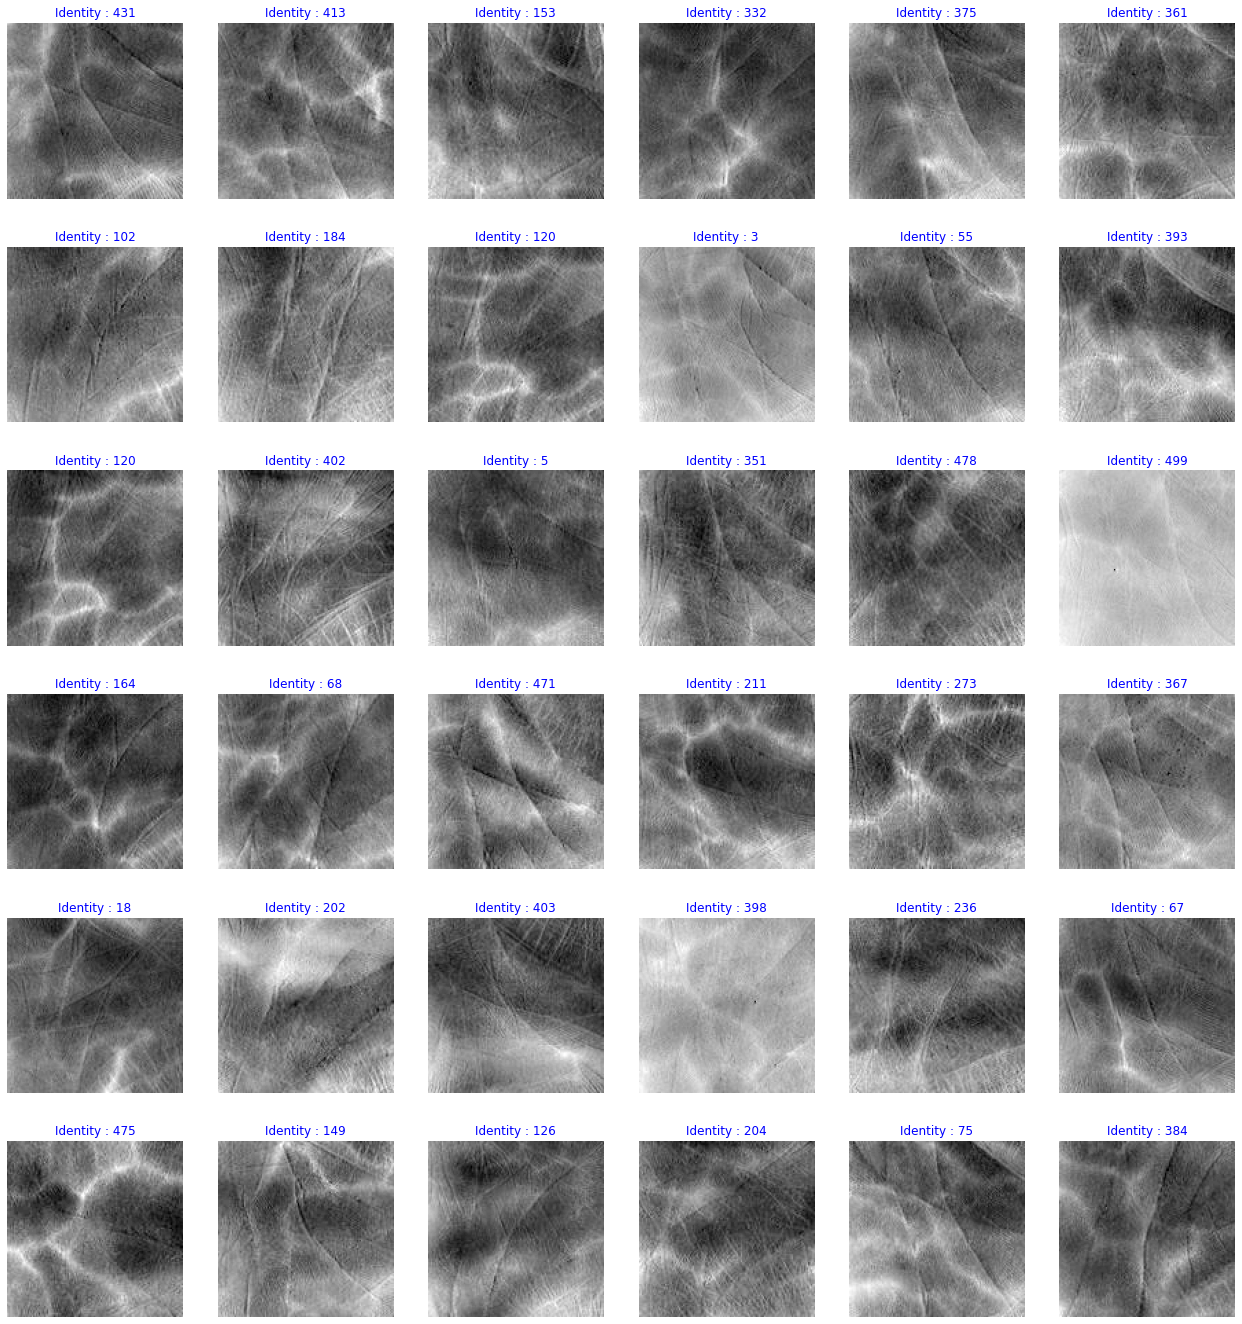

In [7]:
plt.figure(figsize=(22, 24))
print("\n=============================== Show datasets =============================== \n\n")

for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    r = randrange(y.shape[0])
    plt.imshow(X[r], cmap=plt.cm.binary)
    title_obj = plt.title("Identity : {}".format(np.argmax(y[r])))
    plt.setp(title_obj, color='blue')
    plt.axis("off")

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("\nSplitting data ...\n")
print("\n=============================== Splitting data =============================== \n\n")
print("X_train shape   : {:19}    |    y_train shape : {}\n".format(str(X_train.shape), y_train.shape))
print("------------------------------------------------------------------------------")
print("X_val shape     : {:19}    |    y_val shape   : {}\n".format(str(X_val.shape), y_val.shape))
print("------------------------------------------------------------------------------")
print("X_test shape    : {:19}    |    y_test shape  : {}\n".format(str(X_test.shape), y_test.shape))


Splitting data ...


=============================== Splitting data =============================== 


X_train shape   : (4200, 128, 128, 1)    |    y_train shape : (4200, 500)

------------------------------------------------------------------------------
X_val shape     : (900, 128, 128, 1)     |    y_val shape   : (900, 500)

------------------------------------------------------------------------------
X_test shape    : (900, 128, 128, 1)     |    y_test shape  : (900, 500)



In [9]:
from keras.applications.nasnet import NASNetLarge

def resnet_model_tf(input_shape=(128, 128, 1), classes=500):
    resnet = NASNetLarge(weights=None, include_top=False, input_shape=input_shape)
    resnet.tbatch_sizenable = False
    model = Sequential()
    model.add(resnet)
    model.add(Flatten())
    #model.add(Dense(1024, activation='LeakyReLU'))
    #model.add(Dropout(0.5))
    #model.add(Dense(1024, activation='LeakyReLU'))
    #model.add(Dropout(0.5))
    model.add(Dense(classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00000000001)
    return model, learning_rate_reduction

cnn, lr_reduction = resnet_model_tf(classes=y.shape[1])

cnn.compile(
  optimizer='nadam',
  loss='categorical_crossentropy',  
  metrics=['accuracy'],
)

n_epochs = 60 # 30 
n_epochs_cv = 10 # 10  # reduce number of epochs for cross validation for performance reason

n_cv = 3
validation_ratio = 0.10
#define callbacks
#early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)

cnn.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 4, 4, 4032)        84915090  
_________________________________________________________________
flatten (Flatten)            (None, 64512)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               32256500  
Total params: 117,171,590
Trainable params: 116,974,922
Non-trainable params: 196,668
_________________________________________________________________


In [10]:
# Train the default CNN model
history = cnn.fit(
    X_train,
    y_train,
    epochs=n_epochs,  
    validation_data=(X_val, y_val), 
    batch_size=64,
    callbacks=lr_reduction
)

Epoch 1/60
66/66 [==============================] - 494s 7s/step - loss: 9.1118 - accuracy: 0.0026 - val_loss: 4153.6367 - val_accuracy: 0.0044
Epoch 2/60
12/66 [====>.........................] - ETA: 6:27 - loss: 5.8124 - accuracy: 0.0117

KeyboardInterrupt: 

In [ ]:
val = cnn.evaluate(X_test, y_test)

print("\n ================= Evaluation : resnet50V2 model ================= \n")
print("  Results : \n")
print("Loss  : %.2f" % (val[0]))
print("Score : %.2f%%" % (val[1] * 100))

In [ ]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
plot_scores(history)
plot_loss(history)